In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors as cmod
import subprocess as sub

from scipy.integrate import ode

from scipy.interpolate import interp2d

from matplotlib.colors import LinearSegmentedColormap
import matplotlib.animation as animation
from IPython.display import HTML

import matplotlib.patches as mpatches


from matplotlib.animation import PillowWriter  


from scipy.spatial.transform import Rotation as R

from geofuns import *
from FantasyWorld import *
from plotting import *
from demographics import *


import pickle

In [3]:
with open("DemoWorld/world.p", 'rb') as fl:
    world = pickle.load(fl)
with open("DemoWorld/demographics.p", 'rb') as fl:
    demos = pickle.load(fl)

In [4]:
def MakeColArr(Elv,LI,newL):
    colorArr = np.zeros((newL[1],newL[0],4))
    colorArr[LI.T] = cm.YlGn_r(Elv.T/np.max(Elv))[LI]
    colorArr[np.invert(LI.T)] = cm.Blues_r(Elv.T/np.max(Elv))[np.invert(LI.T)]
    return colorArr

In [5]:
np.max(world.Elevation)

1.0533147557513938

In [6]:
Phi = world.GlobeGrid[0][0]
Theta = world.GlobeGrid[1].T[0]
ElevationInterp = interp2d(Phi,Theta,world.Elevation, kind = 'quintic')

In [7]:
MapTheta = mapThetas(world.GlobeGrid)

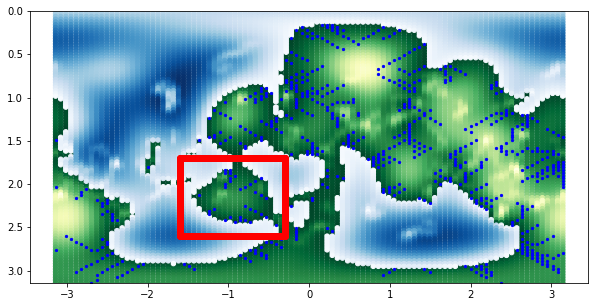

In [8]:
RiverMsk = world.RiverIndicator.reshape(world.GridSize)

fig = plt.figure(figsize = (10,5))
ax = plt.axes()
ax.set_ylim(np.pi,0)

ax.scatter(world.GlobeGrid[1][world.LandIndicator],world.GlobeGrid[0][world.LandIndicator],s=20,c = world.Elevation[world.LandIndicator], cmap = 'YlGn_r')
ax.scatter(world.GlobeGrid[1][np.invert(world.LandIndicator)],world.GlobeGrid[0][np.invert(world.LandIndicator)],s=20,c = world.Elevation[np.invert(world.LandIndicator)], cmap = 'Blues_r')
ax.scatter(world.GlobeGrid[1][RiverMsk],world.GlobeGrid[0][RiverMsk],s=5,color = 'b')

line1 = [[-1.6 for i in range(100)],np.linspace(1.7,2.6,100)]
ax.scatter(line1[0],line1[1],color = 'r')
line2 = [[-0.3 for i in range(100)],np.linspace(1.7,2.6,100)]
ax.scatter(line2[0],line2[1],color = 'r')
line3 = [np.linspace(-1.6,-0.3,100), [1.7 for i in range(100)]]
ax.scatter(line3[0],line3[1],color = 'r')
line4 = [np.linspace(-1.6,-0.3,100), [2.6 for i in range(100)]]
ax.scatter(line4[0],line4[1],color = 'r')

In [9]:
phi = np.linspace(1.7,2.6,500)
theta = np.linspace(-1.6,-0.3,500)
P,T = np.meshgrid(phi,theta)
Local = ElevationInterp(phi,theta)
LocalLand = Local>world.oLevel
LocalWater = np.invert(LocalLand)

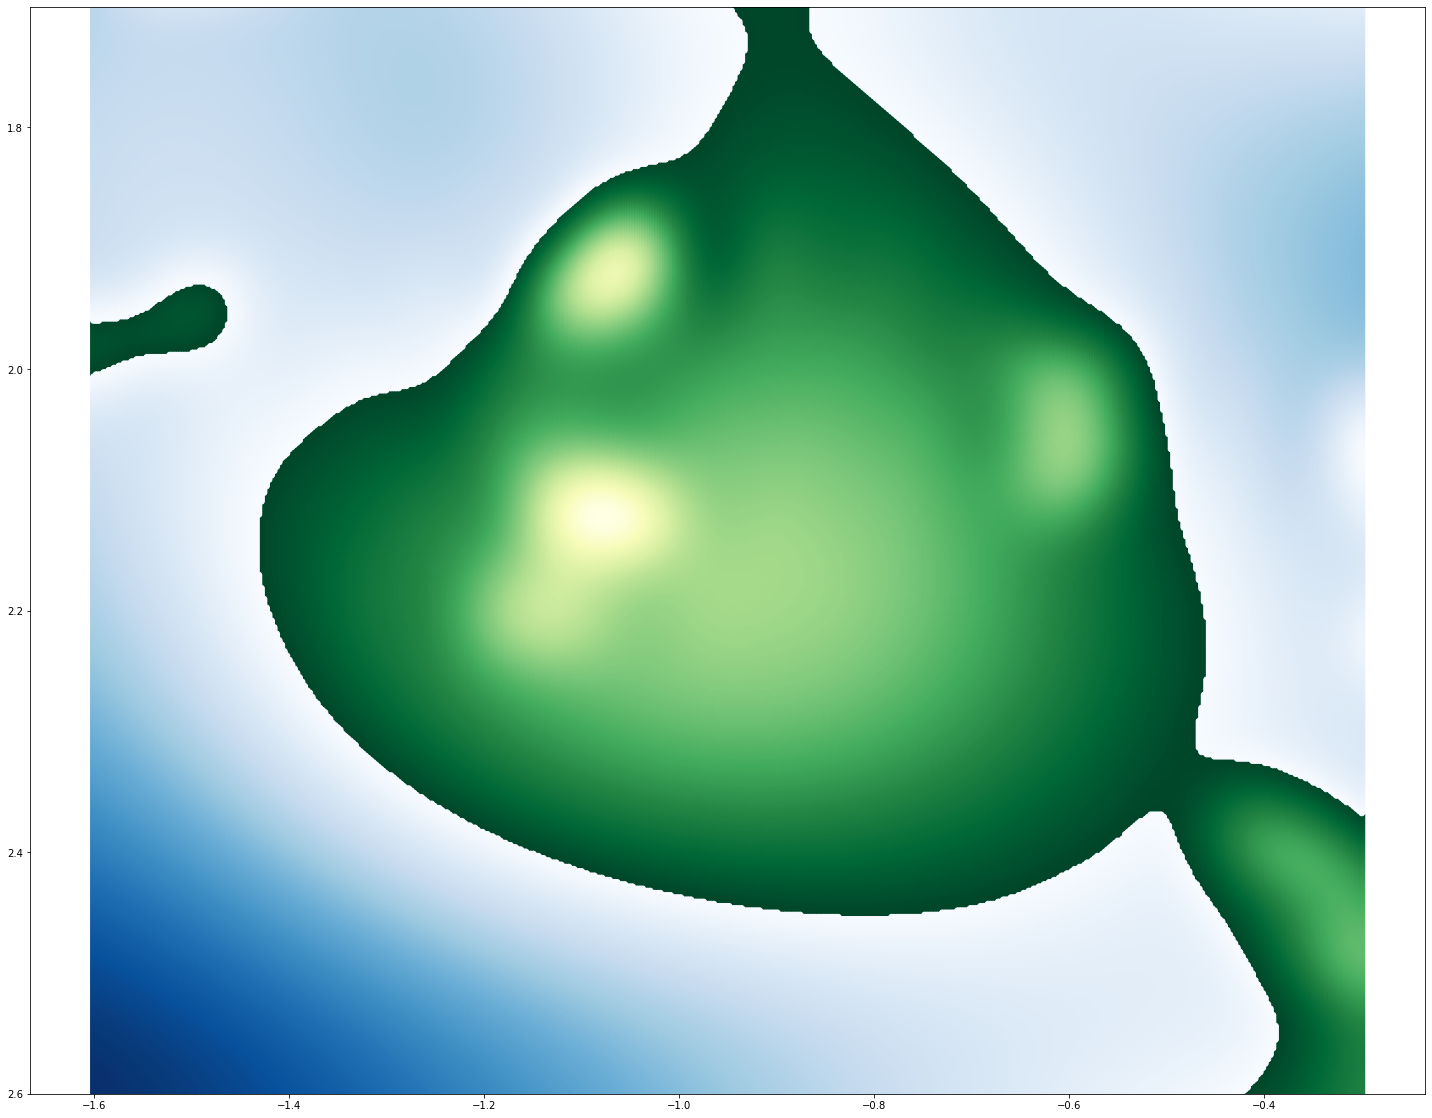

In [10]:
fig = plt.figure(figsize = (25,20))
ax = plt.axes()
ax.set_ylim(2.6,1.7)
# plt.imshow(MakeColArr(Local,LocalLand,Local.shape), interpolation="nearest")
ax.scatter(T[LocalLand],P[LocalLand],c = Local[LocalLand], cmap = 'YlGn_r')
ax.scatter(T[np.invert(LocalLand)],P[np.invert(LocalLand)],c=Local[np.invert(LocalLand)],cmap = 'Blues_r')

In [11]:
countries = demos.PoliticalHistory[-1]

In [12]:
startphi = np.where(world.GlobeGrid[0][0]>1.7)[0][0]
stopphi = np.where(world.GlobeGrid[0][0]>=2.6)[0][0]
startthe = np.where(world.GlobeGrid[1][:,0]>-1.6)[0][0]
stopthe = np.where(world.GlobeGrid[1][:,0]>=-0.3)[0][0]

In [13]:
coarseGrd = (world.GlobeGrid[0][startthe:stopthe,startphi:stopphi],world.GlobeGrid[1][startthe:stopthe,startphi:stopphi])

In [14]:
len(np.unique(countries[startthe:stopthe,startphi:stopphi]))

30

In [15]:
local_pol = countries[startthe:stopthe,startphi:stopphi].astype(int)
# local_pol2 = np.empty_like(local_pol)
# for i in range(len(np.unique(local_pol))):
#     local_pol2[np.where(local_pol == np.unique(local_pol)[i])] = i

In [16]:
import seaborn as sns

In [17]:
def nearest_gp(coord,mshgrid):
    if coord[0]>=mshgrid[0][0][0]:
        lowerX = np.where(mshgrid[0][0]<=coord[0])[0][-1]
    else:
        lowerX = 0
    if coord[0]<=mshgrid[0][0][-1]:
        upperX = np.where(mshgrid[0][0]>=coord[0])[0][0]
    else:
        upperX = len(mshgrid[0][0]) - 1
    if coord[1]>=mshgrid[1][0,0]:
        lowerY = np.where(mshgrid[1][:,0]<=coord[1])[0][-1]
    else:
        lowerY = 0
    if coord[1]<=mshgrid[1][-1,0]:
        upperY = np.where(mshgrid[1][:,0]>=coord[1])[0][0]
    else:
        upperY = len(mshgrid[1][:,0]) - 1
    c1 = (mshgrid[0][lowerY,lowerX],mshgrid[1][lowerY,lowerX]) 
    c2 = (mshgrid[0][lowerY,upperX],mshgrid[1][lowerY,upperX]) 
    c3 = (mshgrid[0][upperY,lowerX],mshgrid[1][upperY,lowerX]) 
    c4 = (mshgrid[0][upperY,upperX],mshgrid[1][upperY,upperX])
    dists = [GCdist(pt,coord) for pt in [c1,c2,c3,c4]]
    return [(lowerY,lowerX),(lowerY,upperX),(upperY,lowerX),(upperY,upperX)][np.argmin(dists)]

In [18]:
local_rivers = [rv for rv in world.RiverLocs if (rv[0]<phi[-1] and rv[0]>phi[0] and rv[1]<theta[-1] and rv[1]>theta[0])]
rivsphi = [rv[0] for rv in local_rivers]
rivthet = [rv[1] for rv in local_rivers]

In [19]:
rivers = []
unassigned = local_rivers
while len(unassigned):
    strt = unassigned[0]
    nearest = [pt for pt in unassigned if GCdist(pt,strt) < np.pi/30]
    river = nearest
    unassigned = [pt for pt in unassigned if pt not in river]
    while len(nearest):
        nearest =[pt for pt in unassigned if GCdist(pt,river[-1]) < np.pi/30]
        river += nearest
        unassigned = [pt for pt in unassigned if pt not in river]
    rivers += [river]


In [20]:
for riv in rivers:
    if ElevationInterp(*riv[-1]) - world.oLevel > 0.01:
        h = 0.001
        dx = (1/(2*h))*(ElevationInterp(riv[-1][0] + h,riv[-1][1]) - ElevationInterp(riv[-1][0] - h,riv[-1][1]))
        dy = (1/(2*h))*(ElevationInterp(riv[-1][0],riv[-1][1] + h) - ElevationInterp(riv[-1][0],riv[-1][1] - h))
        newpt = (riv[-1][0] - 0.01*dx,riv[-1][1] - 0.01*dy)
        fel = ElevationInterp(*newpt) - world.oLevel
        msteps = 20
        stps = 0
        while fel > 0.01 and stps < msteps:
            newpt = (newpt[0] - 0.01*dx,newpt[1] - 0.01*dy)
            fel = ElevationInterp(*newpt) - world.oLevel
            stps += 1
        riv += [newpt]

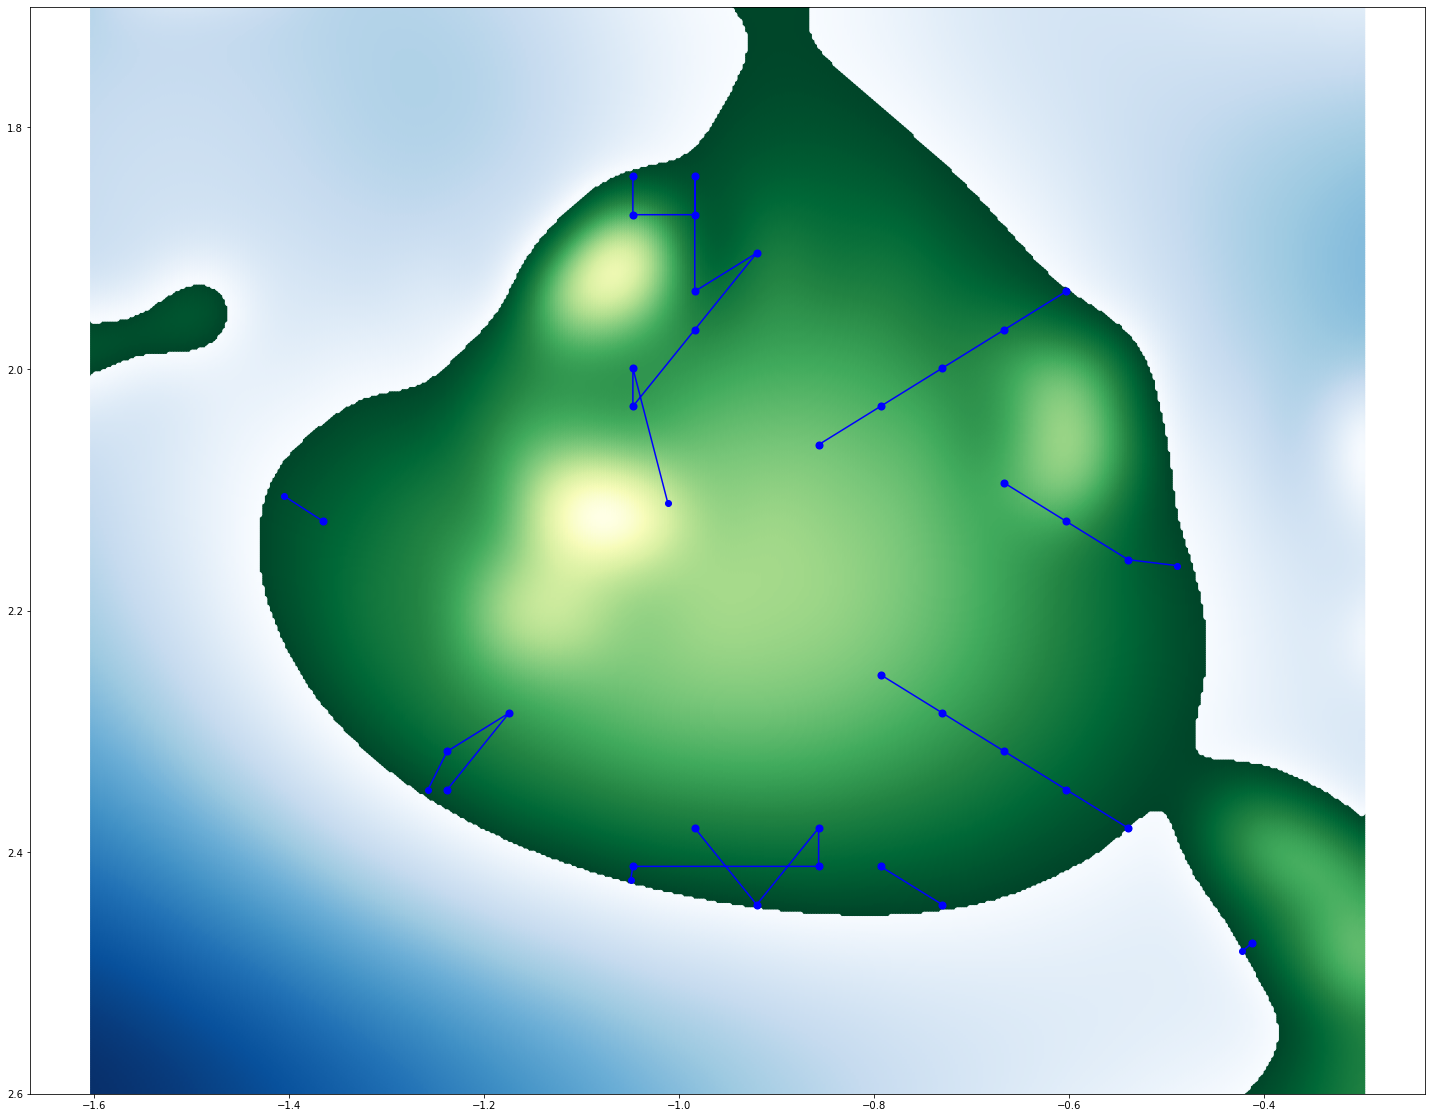

In [21]:
fig = plt.figure(figsize = (25,20))
ax = plt.axes()
ax.set_ylim(2.6,1.7)
# plt.imshow(MakeColArr(Local,LocalLand,Local.shape), interpolation="nearest")
ax.scatter(T[LocalLand],P[LocalLand],c = Local[LocalLand], cmap = 'YlGn_r')
ax.scatter(T[np.invert(LocalLand)],P[np.invert(LocalLand)],c=Local[np.invert(LocalLand)],cmap = 'Blues_r')
ax.scatter(rivthet,rivsphi,s = 50, c = 'b')
for riv in rivers:
    ax.plot([r[1] for r in riv],[r[0] for r in riv],c = 'b',marker = 'o')

In [22]:
def newrpts(a,direc,t):
    x = a[0] + t*direc[0] + (0.1*np.random.rand() + 0.05*np.sin(2*np.pi*t))*direc[1]
    y = a[1] + t*direc[1] - (0.1*np.random.rand() + 0.05*np.sin(2*np.pi*t))*direc[0]
    return (x,y)

In [23]:
def CreateMeander(a,b,res = 100):
    direc = (b[0]-a[0],b[1]-a[1])
    ln = [newrpts(a,direc,t) for t in np.linspace(0,1,res)]
    return ln

In [24]:
rivers2 = []
for riv in rivers:
    riv2 = []
    for i in range(len(riv) - 1):
        riv2 += [CreateMeander(riv[i],riv[i+1],res = 200)]
    rivers2 += riv2

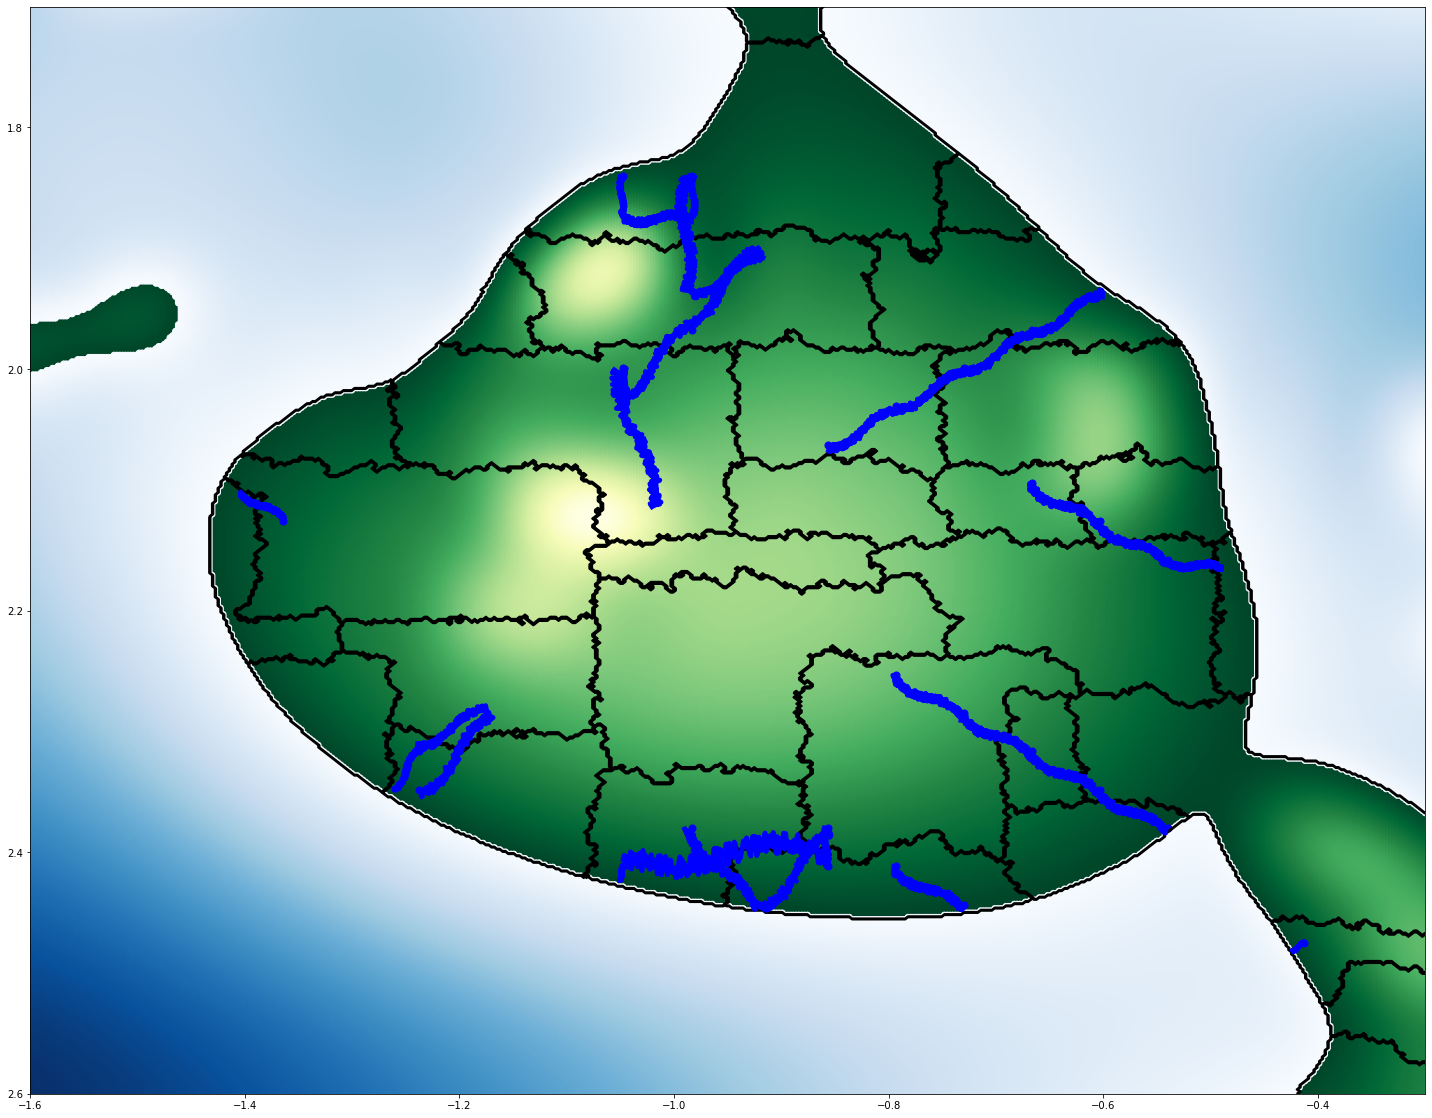

In [46]:
fig = plt.figure(figsize = (25,20))
ax = plt.axes()
ax.set_ylim(2.6,1.7)
# plt.imshow(MakeColArr(Local,LocalLand,Local.shape), interpolation="nearest")
ax.scatter(T[LocalLand],P[LocalLand],c = Local[LocalLand], cmap = 'YlGn_r')
ax.scatter(T[np.invert(LocalLand)],P[np.invert(LocalLand)],c=Local[np.invert(LocalLand)],cmap = 'Blues_r')
ax.scatter(rivthet,rivsphi,s = 50, c = 'b')
for riv in rivers2:
    ax.plot([r[1] for r in riv],[r[0] for r in riv],c = 'b',linewidth=5)
for ci in np.unique(country_detail):
    if ci:
        cionly = (country_detail == ci).astype(int)
        ax.contour(T,P,cionly,levels = 1,colors = 'k',linewidths = 2)

In [29]:
def nearest_gp(coord,mshgrid):
    if coord[0]>=mshgrid[0][0][0]:
        lowerX = np.where(mshgrid[0][0]<=coord[0])[0][-1]
    else:
        lowerX = 0
    if coord[0]<=mshgrid[0][0][-1]:
        upperX = np.where(mshgrid[0][0]>=coord[0])[0][0]
    else:
        upperX = len(mshgrid[0][0]) - 1
    if coord[1]>=mshgrid[1][0,0]:
        lowerY = np.where(mshgrid[1][:,0]<=coord[1])[0][-1]
    else:
        lowerY = 0
    if coord[1]<=mshgrid[1][-1,0]:
        upperY = np.where(mshgrid[1][:,0]>=coord[1])[0][0]
    else:
        upperY = len(mshgrid[1][:,0]) - 1
    c1 = (mshgrid[0][lowerY,lowerX],mshgrid[1][lowerY,lowerX]) 
    c2 = (mshgrid[0][lowerY,upperX],mshgrid[1][lowerY,upperX]) 
    c3 = (mshgrid[0][upperY,lowerX],mshgrid[1][upperY,lowerX]) 
    c4 = (mshgrid[0][upperY,upperX],mshgrid[1][upperY,upperX])
    dists = [GCdist(pt,coord) for pt in [c1,c2,c3,c4]]
    return [(lowerY,lowerX),(lowerY,upperX),(upperY,lowerX),(upperY,upperX)][np.argmin(dists)]

In [38]:
country_detail = np.zeros((Local.shape[0] + 2,Local.shape[1] + 2))
for i in range(len(coarseGrd[0])):
    for j in range(len(coarseGrd[1].T)):
        smlc = nearest_gp((coarseGrd[0][i,j],coarseGrd[1][i,j]),(P,T))
        country_detail[smlc] = local_pol[i,j]

In [39]:
LandPadded = np.concatenate([[[False]*LocalLand.shape[1]],LocalLand,[[False]*LocalLand.shape[1]]])
LandPadded = np.concatenate([np.array([[False]*(LocalLand.shape[1]+2)]).T,LandPadded,np.array([[False]*(LocalLand.shape[1]+2)]).T],axis = 1)

In [40]:
numfld = np.sum(country_detail[LandPadded].astype(bool))
while (not np.all(country_detail[LandPadded])):
    for i in range(1,country_detail.shape[0]-1):
        for j in range(1,country_detail.shape[1]-1):
            if LandPadded[i,j]:
                if country_detail[i,j] == 0:
                    neighbors = [country_detail[i+l,j+k] for k in [-1,0,1] for l in [-1,0,1]]
                    country_detail[i,j] = np.random.choice(neighbors)
    numfld2 = np.sum(country_detail[LandPadded].astype(bool))
    if numfld2 == numfld:
        break
    else:
        numfld = numfld2

In [41]:
country_detail = country_detail[1:-1,1:-1]

In [42]:
country_detail.shape

(500, 500)

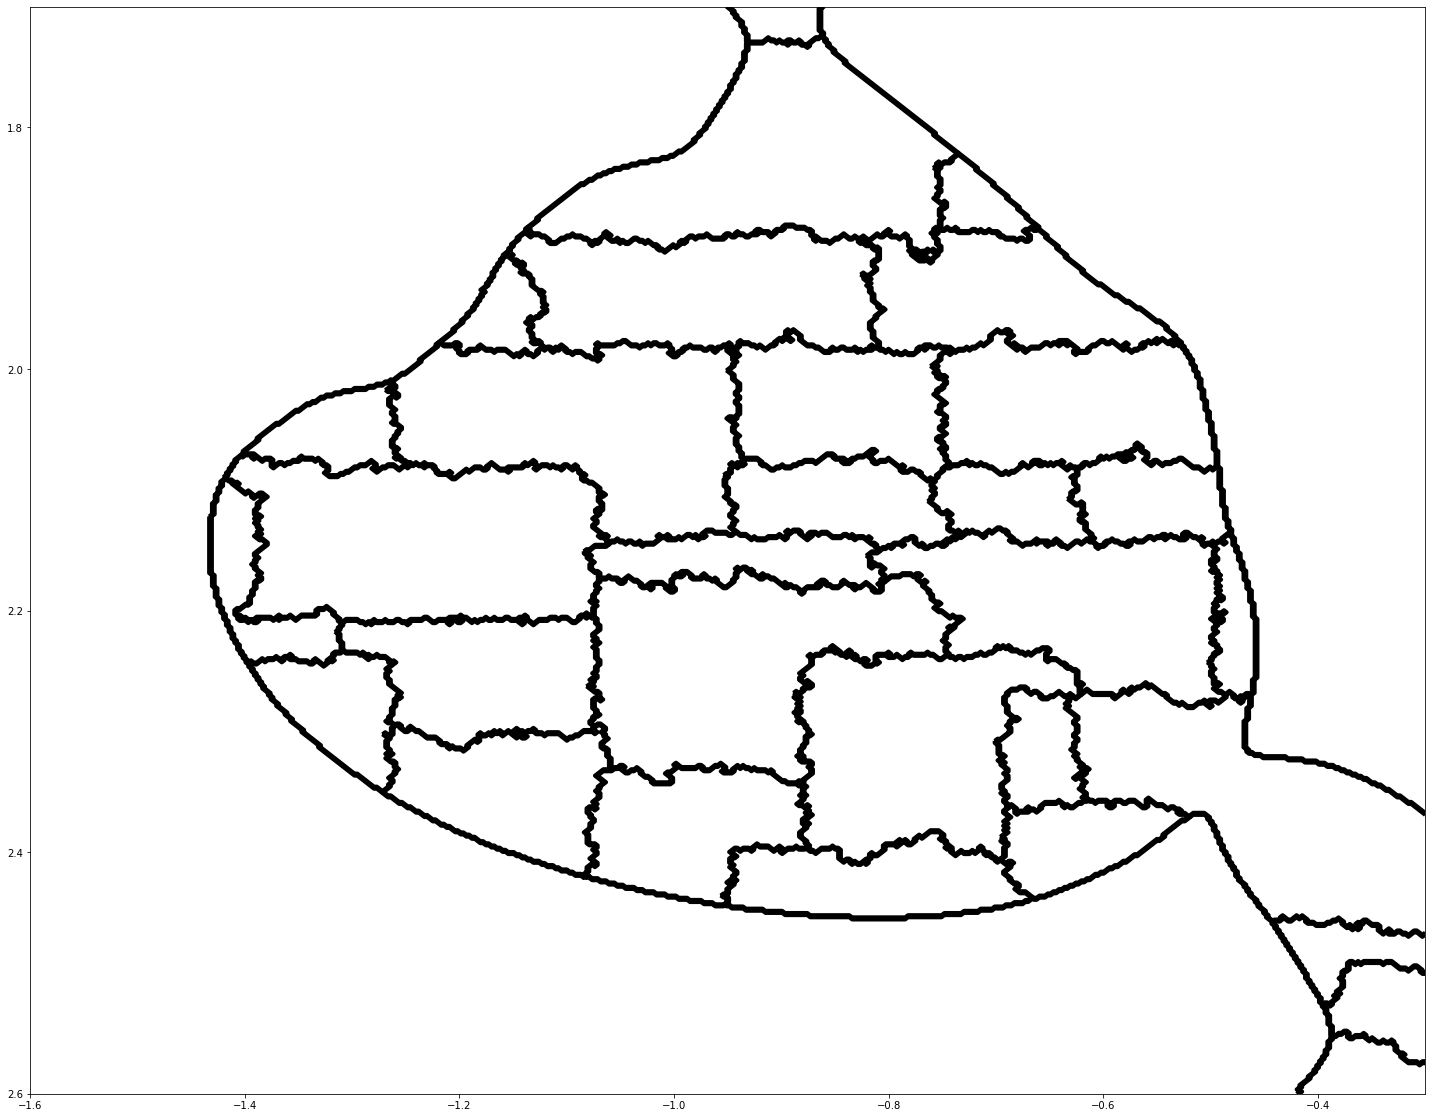

In [43]:
fig = plt.figure(figsize = (25,20))
ax = plt.axes()
ax.set_ylim(2.6,1.7)
for ci in np.unique(country_detail):
    cionly = (country_detail == ci).astype(int)
    ax.contour(T,P,cionly,levels = 1,colors = 'k',linewidths = 4)